# Симуляция торговых сигналов

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

Загрузка 5 минутных данных из файла

In [101]:
df = pd.read_csv('df_m5_TVI_CCI_T3_GHL.csv')
df['tradedate'] = pd.to_datetime(df['tradedate'])
# df.set_index('tradedate', inplace=True)  # Индекс должен быть временной меткой
df

,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,100.00,0,0,0,0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,100.00,1,0,1,0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,100.00,1,0,1,0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,100.00,1,0,1,0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,100.00,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...
410502,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,43.72,1,1,1,1
410503,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,43.74,1,1,1,1
410504,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,43.86,1,1,1,1
410505,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,44.03,1,1,1,1


Создание дата фрейма с колонкой признаков открытия позиции Bay или Sell.

In [102]:
# # Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
# df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# # # Проверка, является ли текущая строка второй подряд с теми же значениями сигналов
# # df['SecondInRow'] = df['IsAllSame'] & df['IsAllSame'].shift(1).fillna(False)

# # Отмечаем только вторую строку в последовательности
# df['SecondInRow'] = (
#     df['IsAllSame'] &  # Текущая строка True
#     df['IsAllSame'].shift(1).fillna(False).astype(bool)  # Предыдущая строка True
# )

# # Создаем колонку 'sig' с условиями
# df['sig'] = 0  # Инициализируем с нулями
# df.loc[df['IsAllSame'] & df['SecondInRow'], 'sig'] = 1  # Записываем 1 при выполнении условий

# # Сохранение в файл
# df.to_csv("signal.csv", index=True)

# # Результат
# print(df)


In [103]:
# Проверка, являются ли все значения в строке одинаковыми [1, 1, 1, 1] или [-1, -1, -1, -1]
df['IsAllSame'] = df[['tvi', 'cci', 't3', 'ghl']].eq(1).all(axis=1) | \
    df[['tvi', 'cci', 't3', 'ghl']].eq(-1).all(axis=1)

# Находим группы последовательных строк, где IsAllSame == True
df['Group'] = (df['IsAllSame'] != df['IsAllSame'].shift(1)).cumsum()

# Отмечаем только вторую строку в каждой группе, где IsAllSame == True
df['SecondInRow'] = df.groupby('Group').cumcount() == 1
df.loc[~df['IsAllSame'], 'SecondInRow'] = False  # Убираем строки, где IsAllSame == False

# Добавляем колонку 'sig', отмечаем только вторую строку в последовательности
df['sig'] = 0
df.loc[df['SecondInRow'], 'sig'] = 1

# Убираем вспомогательную колонку 'Group', 'IsAllSame', 'SecondInRow'
df.drop(columns=['Group', 'IsAllSame', 'SecondInRow'], inplace=True)

# Добавляем колонку с ценой открытия по сигналу
df['sig_open'] = df.apply(lambda x: x.open if x.sig == 1 else 0, axis=1)

# Добавляем колонку с направлением торговли
# df['buy_sell'] = df.apply(
#     lambda x: 1 if ((x.tvi == 1) & (x.cci == 1) & (x.t3 == 1) & (x.ghl == 1) & (x.sig == 1)) 
#     else (-1 if ((x.tvi == -1) & (x.cci == -1) & (x.t3 == -1) & (x.ghl == -1) & (x.sig == 1)) 
#     else 0), 
#     axis=1
# )
conditions = [
    (df['tvi'] == 1) & (df['cci'] == 1) & (df['t3'] == 1) & (df['ghl'] == 1) & (df['sig'] == 1),
    (df['tvi'] == -1) & (df['cci'] == -1) & (df['t3'] == -1) & (df['ghl'] == -1) & (df['sig'] == 1)
]
choices = [1, -1]
df['buy_sell'] = np.select(conditions, choices, default=0)

Создаем колонку "profit" в которую записываем:  
если значение в колонке 'buy_sell' равно 1, то из ближайшего последующего значения в колонке 'sig_open' не равного 0, вычесть текущее значение в колонке 'sig_open'  
если значение в колонке 'buy_sell' равно -1, то из текущего значения в колонке 'sig_open', вычесть ближайшее последующее значение в колонке 'sig_open' не равное 0  
иначе, записать в колонку 0

In [104]:
# profits = []
# for i in range(len(df)):
#     buy_sell = df.loc[i, 'buy_sell']
#     sig_open = df.loc[i, 'sig_open']

#     if buy_sell == 1:
#         # Найти ближайшее последующее значение не равное 0
#         next_values = df.loc[i + 1:, 'sig_open']
#         for next_value in next_values:
#             if next_value != 0:
#                 profits.append(next_value - sig_open)
#                 break
#         else:
#             profits.append(0)  # Если нет подходящего значения
#     elif buy_sell == -1:
#         # Найти ближайшее последующее значение не равное 0
#         next_values = df.loc[i + 1:, 'sig_open']
#         for next_value in next_values:
#             if next_value != 0:
#                 profits.append(sig_open - next_value)
#                 break
#         else:
#             profits.append(0)  # Если нет подходящего значения
#     else:
#         profits.append(0)

# df['profit'] = profits
# # print(df)

In [105]:
def calculate_profit(row, sig_open_col, buy_sell_col):
    # Индекс текущей строки
    current_index = row.name

    # Значение buy_sell для текущей строки
    buy_sell = row[buy_sell_col]
    sig_open = row[sig_open_col]

    # Если buy_sell равно 1
    if buy_sell == 1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return next_value - sig_open

    # Если buy_sell равно -1
    elif buy_sell == -1:
        # Найти ближайшее последующее значение в sig_open, не равное 0
        for next_value in df.loc[current_index + 1:, sig_open_col]:
            if next_value != 0:
                return sig_open - next_value

    # Если buy_sell не равно 1 или -1
    return 0

# Применить функцию ко всем строкам
df['profit'] = df.apply(calculate_profit, axis=1, sig_open_col='sig_open', buy_sell_col='buy_sell')

# # Результат
# print(df)

In [106]:
# # Сохранение в файл
# df.to_csv("signal.csv", index=True)
# df.to_excel('signal.xlsx')

# Результат
df

,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit
0,2015-01-05 10:00:00,78450.0,78450.0,73200.0,73930.0,100.00,0,0,0,0,0,0.0,0,0.0
1,2015-01-05 10:05:00,73890.0,74700.0,73660.0,74700.0,100.00,1,0,1,0,0,0.0,0,0.0
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,100.00,1,0,1,0,0,0.0,0,0.0
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,100.00,1,0,1,0,0,0.0,0,0.0
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,100.00,1,0,1,0,0,0.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410502,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,43.72,1,1,1,1,0,0.0,0,0.0
410503,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,43.74,1,1,1,1,0,0.0,0,0.0
410504,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,43.86,1,1,1,1,0,0.0,0,0.0
410505,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,44.03,1,1,1,1,0,0.0,0,0.0


In [107]:
df['dif_per'] = df['avg_per'].diff().shift(1)
df.dropna(inplace=True)
df


,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,dif_per
2,2015-01-05 10:10:00,74700.0,74720.0,73830.0,73950.0,100.00,1,0,1,0,0,0.0,0,0.0,0.00
3,2015-01-05 10:15:00,73970.0,74440.0,73620.0,74430.0,100.00,1,0,1,0,0,0.0,0,0.0,0.00
4,2015-01-05 10:20:00,74400.0,74720.0,74220.0,74410.0,100.00,1,0,1,0,0,0.0,0,0.0,0.00
5,2015-01-05 10:25:00,74420.0,74420.0,73600.0,73610.0,100.00,1,0,-1,-1,0,0.0,0,0.0,0.00
6,2015-01-05 10:30:00,73630.0,73910.0,73320.0,73490.0,100.00,1,0,-1,-1,0,0.0,0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410502,2024-12-17 23:25:00,72680.0,72720.0,72680.0,72690.0,43.72,1,1,1,1,0,0.0,0,0.0,-0.09
410503,2024-12-17 23:30:00,72680.0,72690.0,72670.0,72690.0,43.74,1,1,1,1,0,0.0,0,0.0,0.14
410504,2024-12-17 23:35:00,72700.0,72790.0,72690.0,72790.0,43.86,1,1,1,1,0,0.0,0,0.0,0.02
410505,2024-12-17 23:40:00,72800.0,72820.0,72760.0,72810.0,44.03,1,1,1,1,0,0.0,0,0.0,0.12


In [108]:
# Учёт всех возможных значений (например, 0 и 1)
sig_counts = df['sig'].value_counts().reindex([0, 1], fill_value=0)
print(sig_counts)
# print(type(sig_counts))
print(sig_counts[1] / sig_counts[0])

sig
0    374619
1     35886
Name: count, dtype: int64
0.09579332601923554


# Исследования

In [109]:
# Очистка df
df = df[df["profit"] != 0.0]

df

,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,dif_per
20,2015-01-05 11:40:00,74380.0,74560.0,74340.0,74560.0,100.00,1,1,1,1,1,74380.0,1,1200.0,0.00
32,2015-01-05 12:40:00,75580.0,75920.0,75480.0,75600.0,100.00,1,1,1,1,1,75580.0,1,-360.0,0.00
47,2015-01-05 13:55:00,75220.0,75300.0,74890.0,75030.0,100.00,-1,-1,-1,-1,1,75220.0,-1,-120.0,0.00
57,2015-01-05 14:45:00,75340.0,75610.0,75320.0,75460.0,100.00,1,1,1,1,1,75340.0,1,-240.0,0.00
63,2015-01-05 15:15:00,75100.0,75120.0,74670.0,74790.0,100.00,-1,-1,-1,-1,1,75100.0,-1,820.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410460,2024-12-17 19:55:00,72400.0,72550.0,72380.0,72460.0,43.79,1,1,1,1,1,72400.0,1,90.0,0.13
410468,2024-12-17 20:35:00,72490.0,72530.0,72470.0,72500.0,42.99,1,1,1,1,1,72490.0,1,-10.0,-0.05
410472,2024-12-17 20:55:00,72480.0,72510.0,72470.0,72480.0,43.28,1,1,1,1,1,72480.0,1,-80.0,0.04
410478,2024-12-17 21:25:00,72400.0,72440.0,72380.0,72420.0,43.89,-1,-1,-1,-1,1,72400.0,-1,-130.0,0.15


In [110]:
# Преобразуем колонку tradedate в формат datetime
df["tradedate"] = pd.to_datetime(df["tradedate"])

# Фильтрация строк с марта 2015 и времени до 19:00:00
df = df[
    (df["tradedate"] >= pd.Timestamp("2015-03-01")) & 
    (df["tradedate"].dt.time < pd.to_datetime("19:00:00").time())
]

df = df.copy()

df


C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\2908991641.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tradedate"] = pd.to_datetime(df["tradedate"])


,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,dif_per
6173,2015-03-02 10:05:00,89890.0,90030.0,89550.0,89760.0,39.51,-1,-1,-1,-1,1,89890.0,-1,-170.0,1.06
6185,2015-03-02 11:05:00,90060.0,90220.0,89980.0,90060.0,44.70,1,1,1,1,1,90060.0,1,510.0,2.54
6196,2015-03-02 12:00:00,90570.0,90580.0,90270.0,90350.0,37.23,1,1,1,1,1,90570.0,1,-450.0,0.43
6217,2015-03-02 13:45:00,90120.0,90200.0,90070.0,90140.0,30.32,-1,-1,-1,-1,1,90120.0,-1,220.0,-0.38
6226,2015-03-02 14:30:00,89900.0,89930.0,89530.0,89670.0,30.73,-1,-1,-1,-1,1,89900.0,-1,50.0,0.61
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410385,2024-12-17 13:20:00,73760.0,73820.0,73730.0,73790.0,37.58,-1,-1,-1,-1,1,73760.0,-1,220.0,-0.24
410396,2024-12-17 14:20:00,73540.0,73540.0,73330.0,73340.0,37.67,-1,-1,-1,-1,1,73540.0,-1,290.0,0.30
410413,2024-12-17 15:45:00,73250.0,73260.0,73150.0,73220.0,42.49,1,1,1,1,1,73250.0,1,-270.0,-0.13
410419,2024-12-17 16:15:00,72980.0,72990.0,72720.0,72770.0,41.44,-1,-1,-1,-1,1,72980.0,-1,370.0,-0.24


In [111]:
# Выборка только от -2000 до 2000
df_2000 = df.query("`profit` > -2000 and `profit` < 2000")

Для исследования значений колонки 'profit' в вашем DataFrame можно использовать несколько подходов, чтобы понять распределение, особенности и взаимосвязи данных. Вот несколько методов анализа:

### 1. Основные статистики:  
Для начала полезно получить описательные статистики для колонки profit, чтобы понять её распределение, средние значения и возможные выбросы.  

Это даст вам информацию о:

* count: количество значений.  
* mean: среднее значение.  
* std: стандартное отклонение.  
* min, 25%, 50%, 75%, max: минимальное значение, квартиль 1, медиана (квартиль 2), квартиль 3 и максимальное значение.  

In [112]:
# Описательные статистики для колонки 'profit'
print(df['profit'].describe())

count    23461.000000
mean        60.409616
std        600.484174
min     -13180.000000
25%       -210.000000
50%         10.000000
75%        240.000000
max      25370.000000
Name: profit, dtype: float64


### 2. Частотное распределение:
Подсчитаем, сколько раз встречаются различные значения в колонке profit.  
Это поможет выявить, какие значения доминируют в колонке (например, сколько раз profit == 0, сколько раз profit > 0 и т.д.).

In [113]:
# Подсчет количества каждого значения
print(df['profit'].value_counts())

profit
 50.0      340
 30.0      334
 10.0      332
-140.0     325
 70.0      324
          ... 
 4460.0      1
 3390.0      1
 2140.0      1
 3780.0      1
-4570.0      1
Name: count, Length: 545, dtype: int64


### 3. Визуализация распределения:  
Для более детального анализа можно построить гистограмму или график плотности распределения (например, с помощью matplotlib или seaborn).  

Гистограмма:  

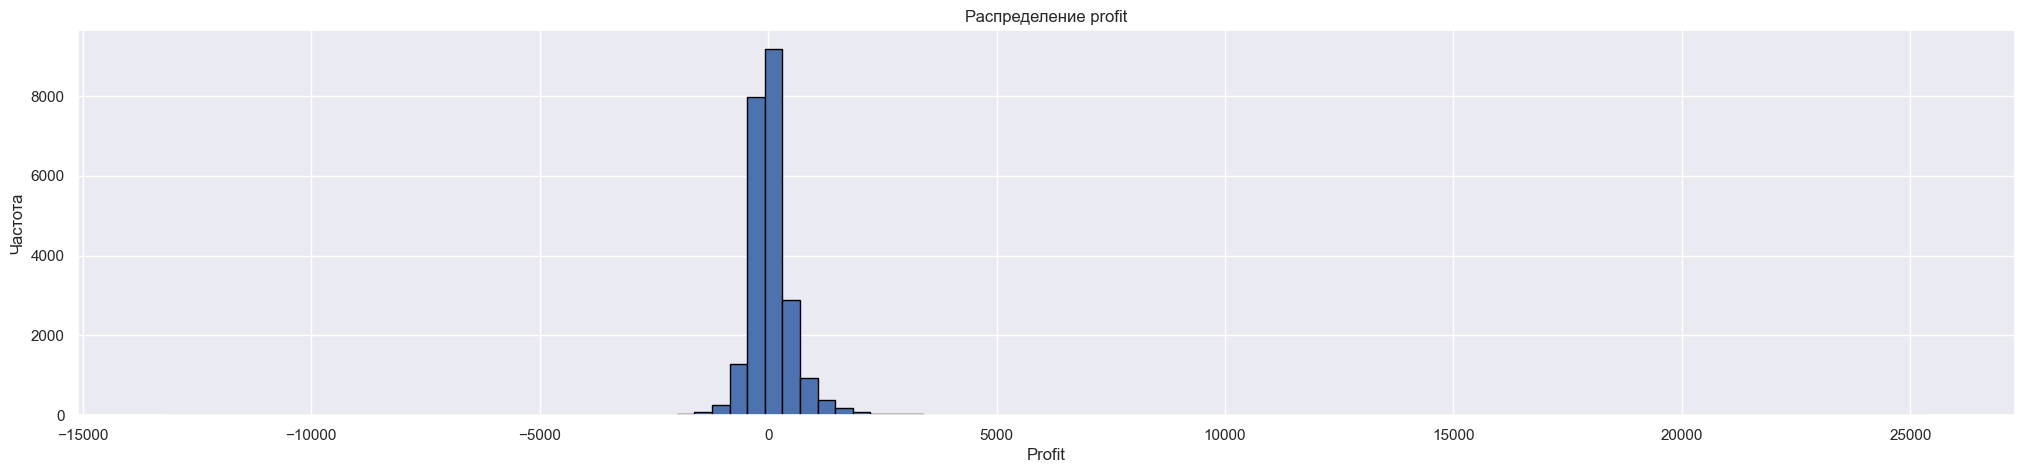

In [114]:
# Гистограмма для 'profit'
df['profit'].hist(bins=100, edgecolor='black')
plt.title('Распределение profit')
plt.xlabel('Profit')
plt.ylabel('Частота')
plt.show()

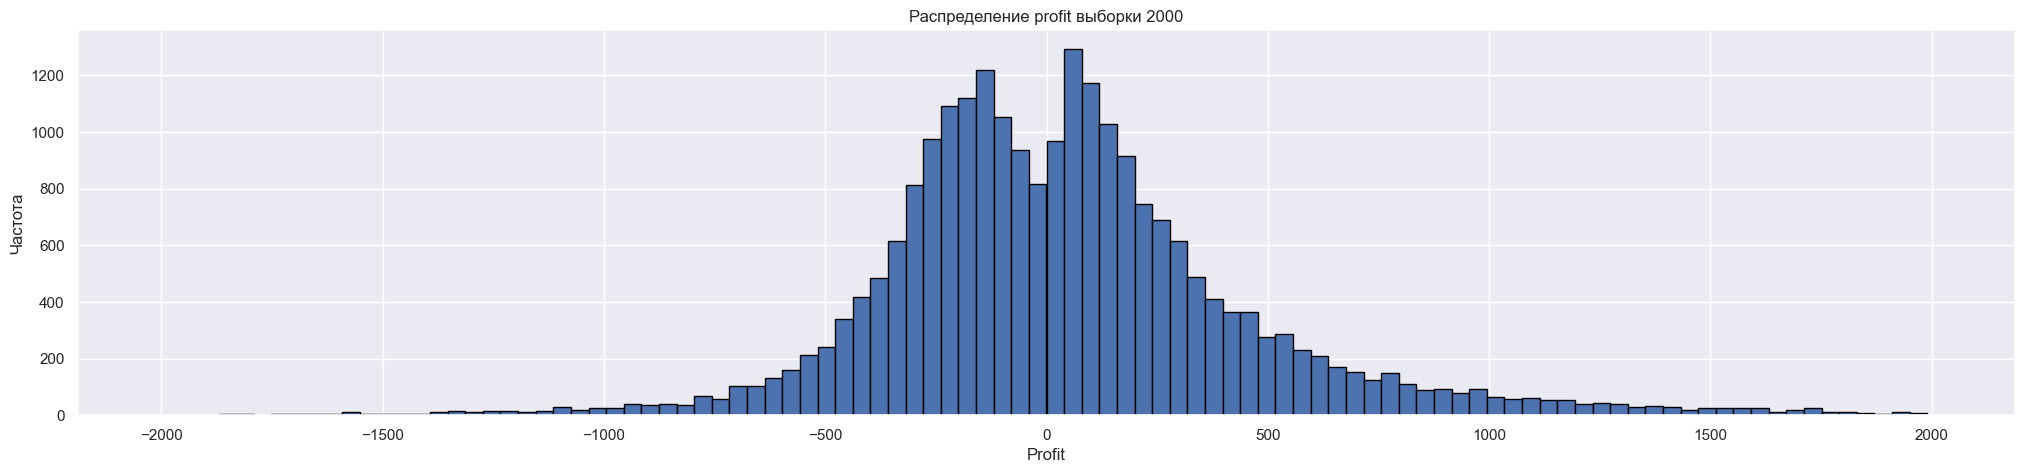

In [115]:
# Гистограмма для 'profit' выборки 2000
df_2000['profit'].hist(bins=100, edgecolor='black')
plt.title('Распределение profit выборки 2000')
plt.xlabel('Profit')
plt.ylabel('Частота')
plt.show()

График плотности (для непрерывных данных):  

Эти графики помогут вам визуализировать распределение значений в колонке profit и выявить возможные выбросы или аномалии.

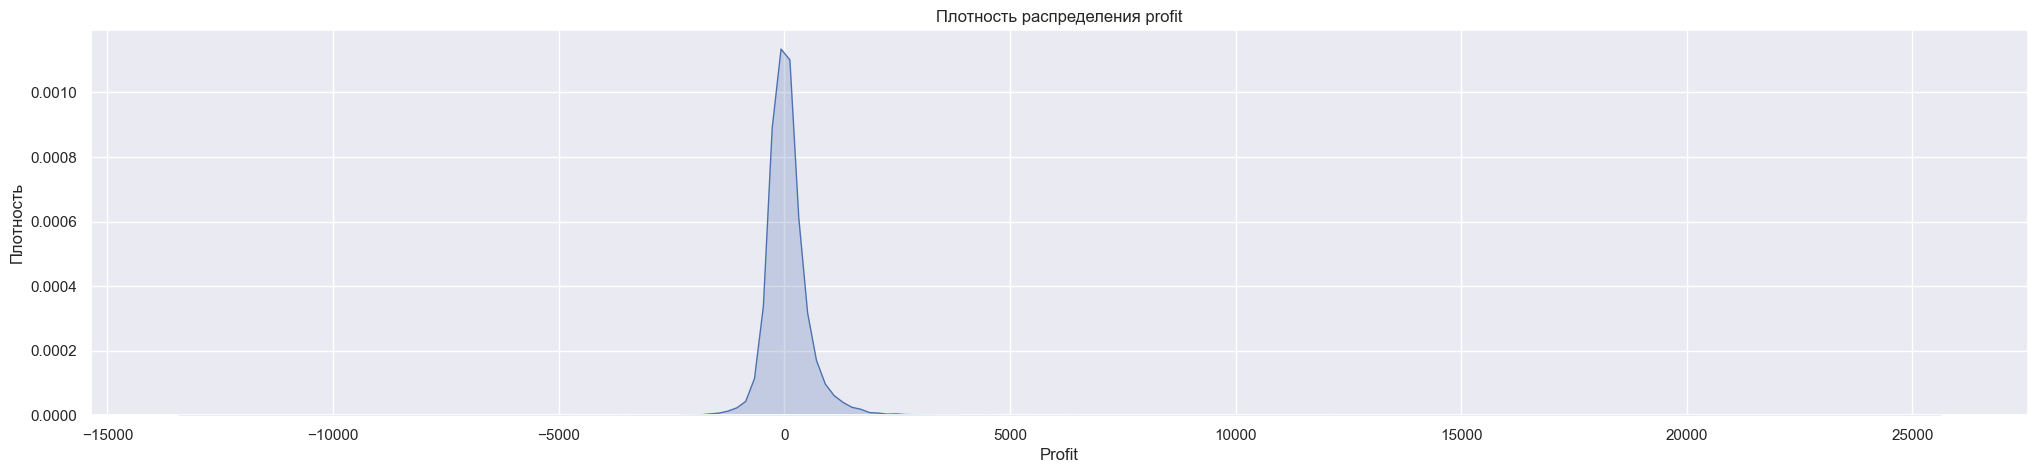

In [116]:
# График плотности для 'profit'
sns.kdeplot(df['profit'], fill=True)
plt.title('Плотность распределения profit')
plt.xlabel('Profit')
plt.ylabel('Плотность')
plt.show()

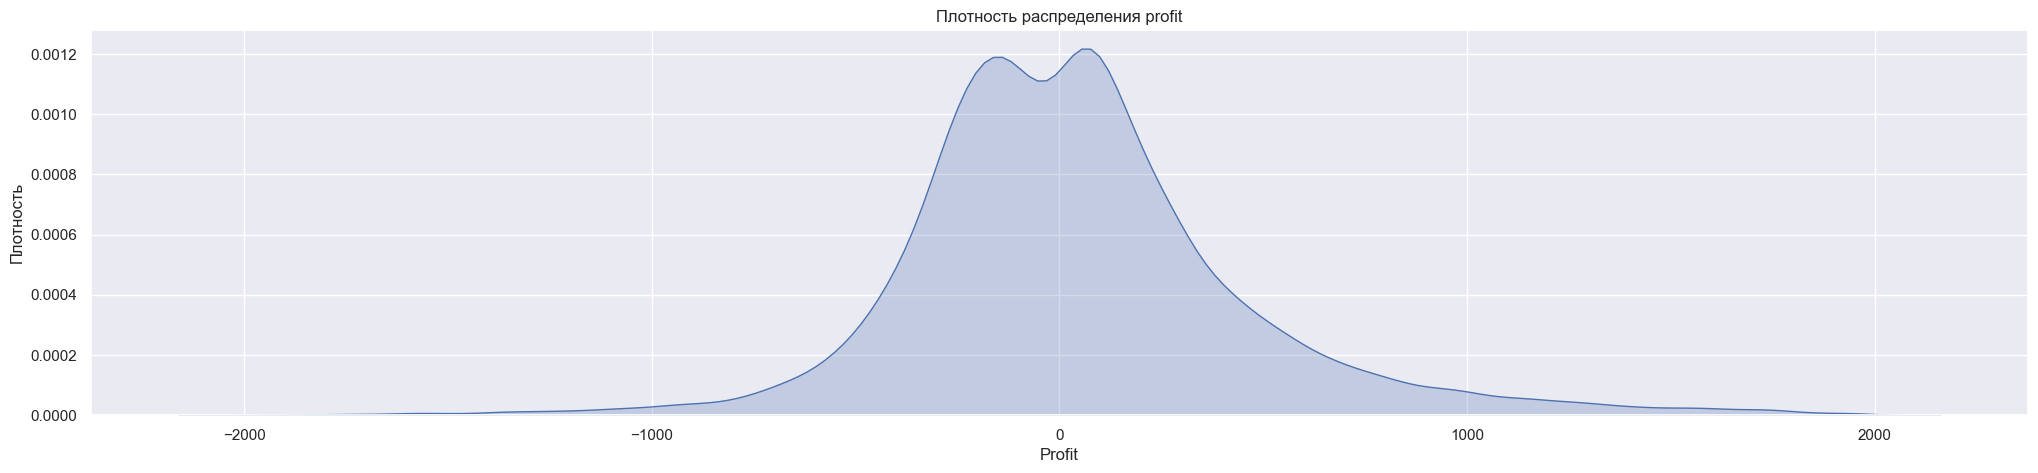

In [117]:
# График плотности для 'profit' для 2000
sns.kdeplot(df_2000['profit'], fill=True)
plt.title('Плотность распределения profit')
plt.xlabel('Profit')
plt.ylabel('Плотность')
plt.show()

### 4. Выявление выбросов:  
Можно использовать метод boxplot (диаграмма размаха), чтобы выявить выбросы в колонке profit.  

Диаграмма размаха поможет вам увидеть:

Медиану (в средней линии коробки).
Интерквартильный размах (между нижней и верхней границей коробки).
Потенциальные выбросы (точки за пределами «усов» коробки).

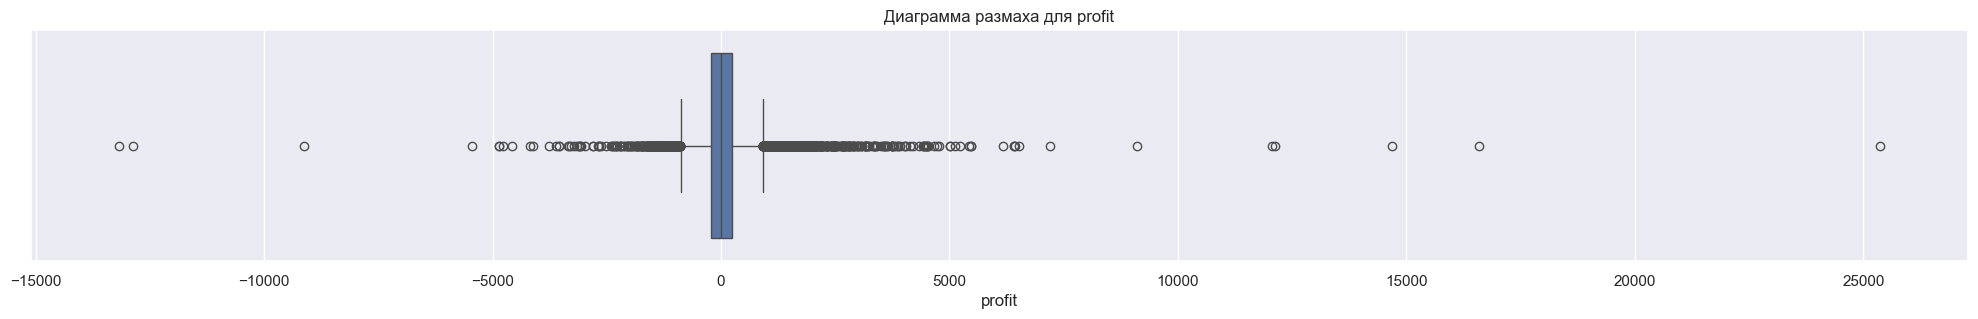

In [118]:
# Boxplot для 'profit'
sns.set(rc={'figure.figsize':(25,3)})
sns.boxplot(x=df['profit'])
plt.title('Диаграмма размаха для profit')
plt.show()


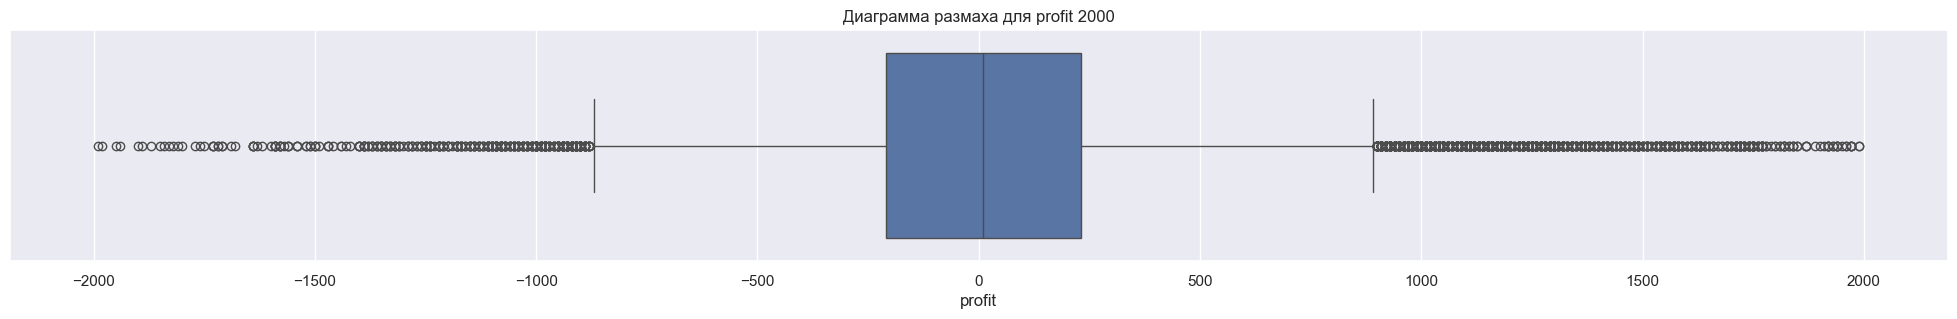

In [119]:
# Boxplot для 'profit' 2000
sns.set(rc={'figure.figsize':(25,3)})
sns.boxplot(x=df_2000['profit'])
plt.title('Диаграмма размаха для profit 2000')
plt.show()

<Axes: xlabel='profit'>

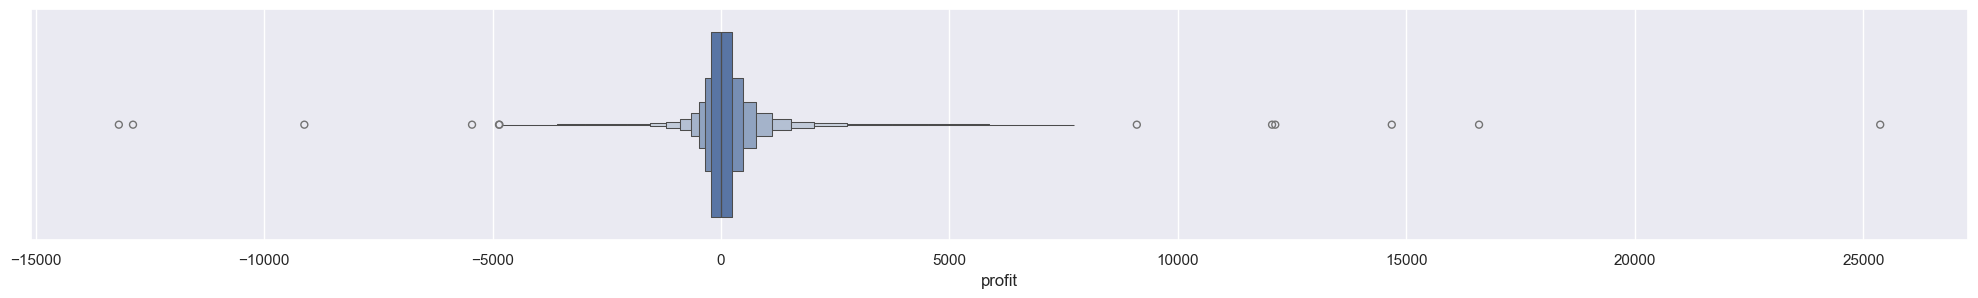

In [120]:
sns.set(rc={'figure.figsize':(25,3)})
sns.boxenplot(x=df['profit'])

<Axes: xlabel='profit'>

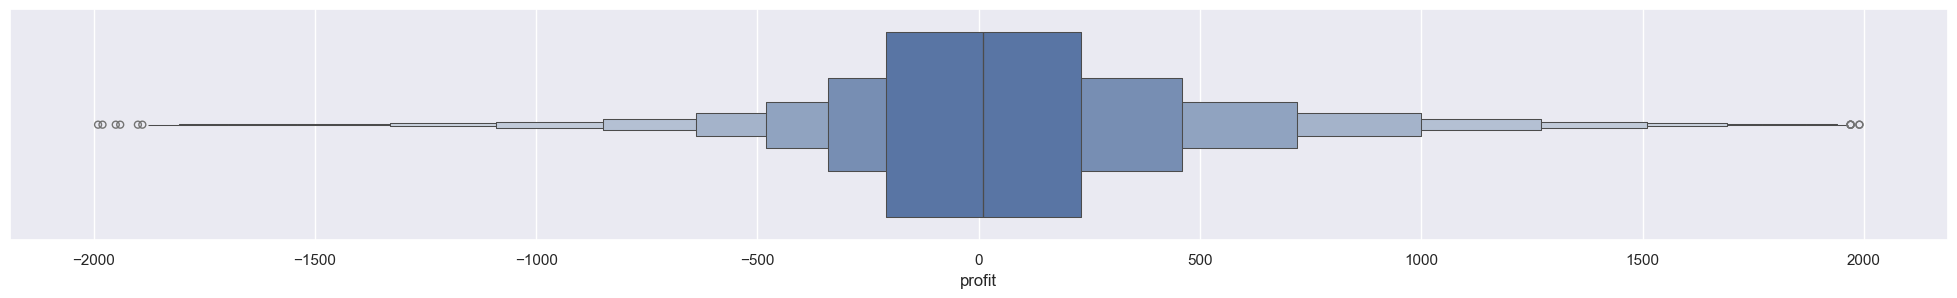

In [121]:
sns.set(rc={'figure.figsize':(25,3)})
sns.boxenplot(x=df_2000['profit'])

# 5. Корреляция с другими колонками:
Если вы хотите проверить, есть ли какая-либо зависимость между колонкой profit и другими колонками, например, buy_sell, sig_open и т. д., можно использовать корреляцию или визуализировать зависимости.

Корреляция:

In [122]:
# Корреляция между 'profit' и другими колонками
correlation = df.corr()
print(correlation['profit'])


tradedate    0.009835
open         0.005630
high         0.006280
low          0.004156
close        0.004671
avg_per     -0.005082
tvi         -0.013088
cci         -0.013088
t3          -0.013088
ghl         -0.013088
sig               NaN
sig_open     0.005630
buy_sell    -0.013088
profit       1.000000
dif_per     -0.004141
Name: profit, dtype: float64


Это покажет, насколько сильно profit коррелирует с другими числовыми колонками в DataFrame.

Визуализация зависимости:

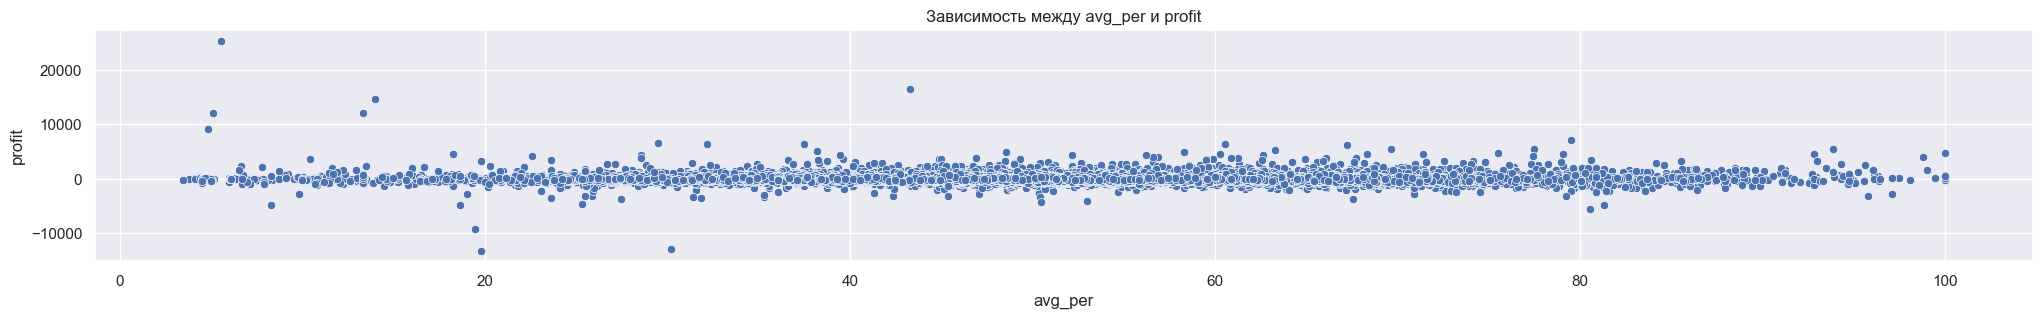

In [123]:
# С scatter plot для 'profit' и 'avg_per'
sns.scatterplot(x=df['avg_per'], y=df['profit'])
plt.title('Зависимость между avg_per и profit')
plt.xlabel('avg_per')
plt.ylabel('profit')
plt.show()


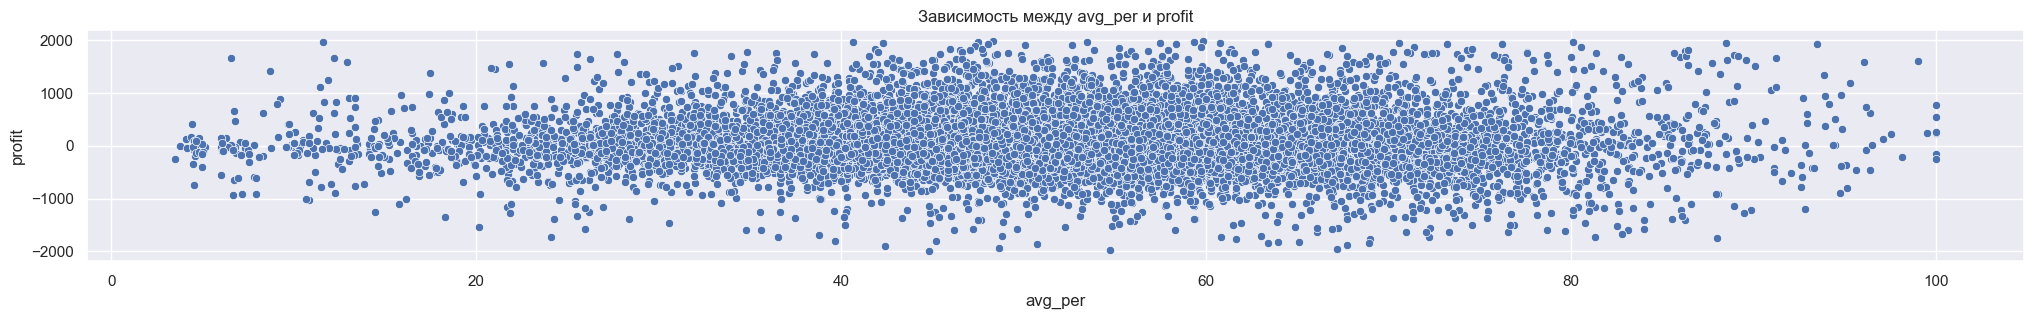

In [124]:
# С scatter plot для 'profit' и 'avg_per'
sns.scatterplot(x=df_2000['avg_per'], y=df_2000['profit'])
plt.title('Зависимость между avg_per и profit')
plt.xlabel('avg_per')
plt.ylabel('profit')
plt.show()

Если значений всё ещё слишком много:
Можно добавить шаг для усреднения или биннинга данных по колонке 'avg_per'. Это полезно, если значения сильно разбросаны.

Пояснение биннинга:
1. pd.cut:
    * Делит значения 'avg_per' на диапазоны (бины) по равномерной шкале.
    * Например, если диапазон 'avg_per' от 0 до 100, создаётся 10 интервалов по 10 единиц.
2. groupby:
    * Группирует данные по созданным диапазонам.
3. График:
    * Используется barplot для отображения суммы 'profit' по диапазонам 'avg_per'.  
    
Это улучшит наглядность данных при большом количестве уникальных значений в колонке 'avg_per'.

C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\2248770023.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(bins)['profit'].sum().reset_index()


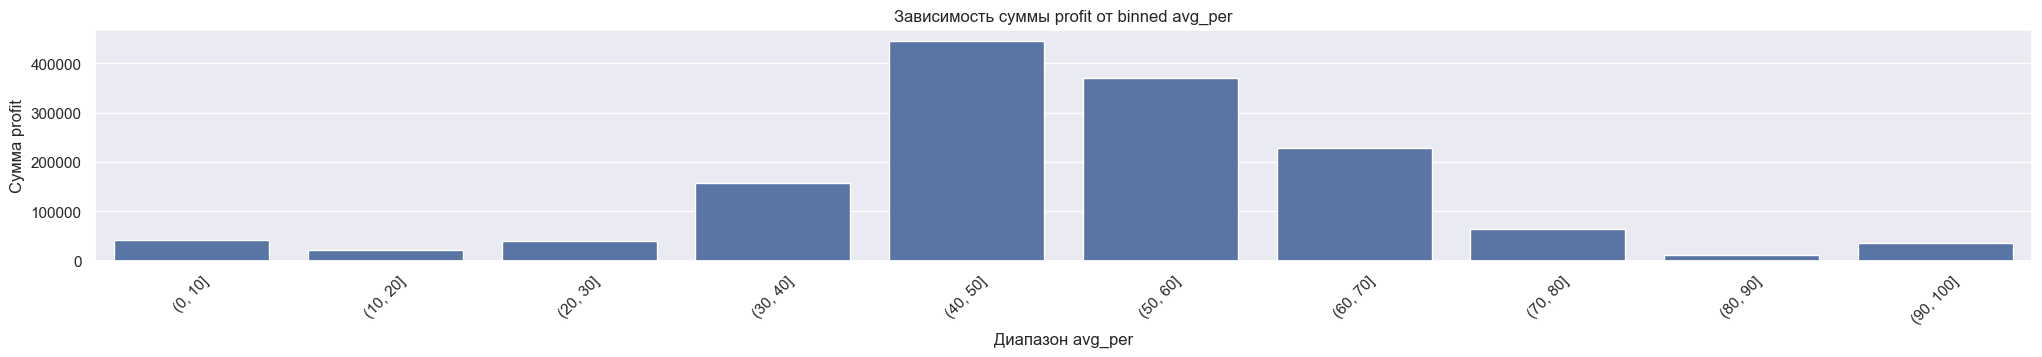

In [125]:
# # Создаем биннинг для 'avg_per'
# bins = pd.cut(df['avg_per'], bins=10)  # Разделяем 'avg_per' на 10 групп
# grouped_data = df.groupby(bins)['profit'].sum().reset_index()

# # Строим график зависимости
# sns.barplot(x=grouped_data['avg_per'].astype(str), y=grouped_data['profit'])
# plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
# plt.title('Зависимость суммы profit от binned avg_per')
# plt.xlabel('Диапазон avg_per')
# plt.ylabel('Сумма profit')
# plt.show()

# Создаем список границ бинов от 0 до 100 с шагом 10
custom_bins = list(range(0, 101, 10))

# Создаем биннинг для 'avg_per' с пользовательскими диапазонами
bins = pd.cut(df['avg_per'], bins=custom_bins)

# Группируем данные и суммируем 'profit'
grouped_data = df.groupby(bins)['profit'].sum().reset_index()

# Строим график зависимости
sns.barplot(x=grouped_data['avg_per'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned avg_per')
plt.xlabel('Диапазон avg_per')
plt.ylabel('Сумма profit')
plt.show()


C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\2508214314.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()


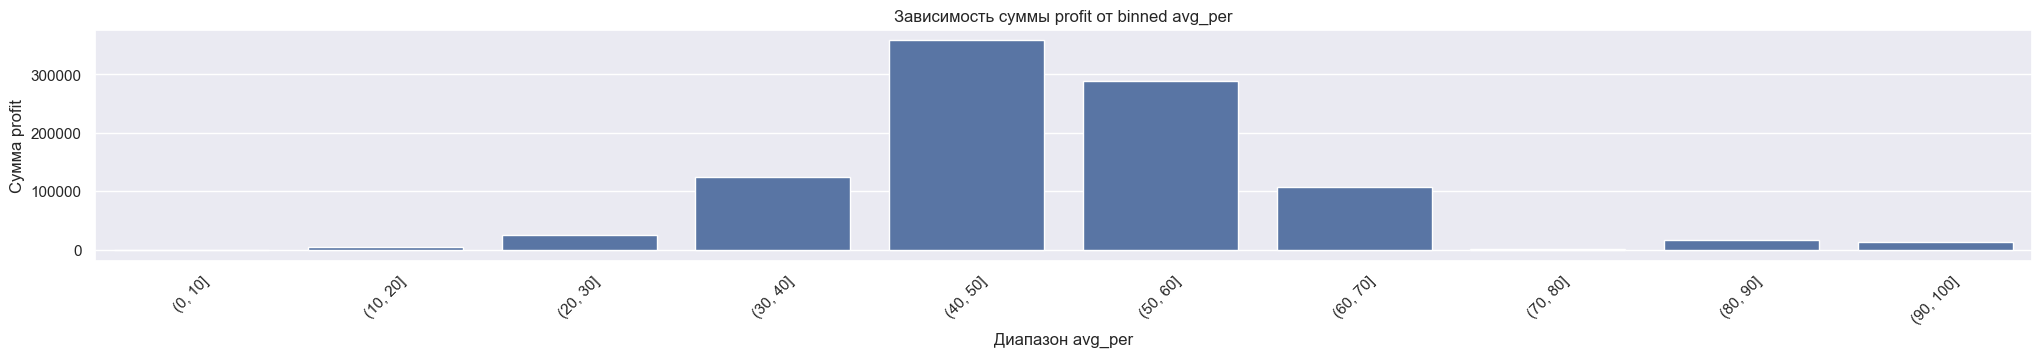

In [126]:
# # Создаем биннинг для 'avg_per'
# bins = pd.cut(df_2000['avg_per'], bins=10)  # Разделяем 'avg_per' на 10 групп
# grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()

# # Строим график зависимости
# sns.barplot(x=grouped_data['avg_per'].astype(str), y=grouped_data['profit'])
# plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
# plt.title('Зависимость суммы profit от binned avg_per')
# plt.xlabel('Диапазон avg_per')
# plt.ylabel('Сумма profit')
# plt.show()

# Создаем список границ бинов от 0 до 100 с шагом 10
custom_bins = list(range(0, 101, 10))

# Создаем биннинг для 'avg_per' с пользовательскими диапазонами
bins = pd.cut(df_2000['avg_per'], bins=custom_bins)

# Группируем данные и суммируем 'profit'
grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()

# Строим график зависимости
sns.barplot(x=grouped_data['avg_per'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned avg_per')
plt.xlabel('Диапазон avg_per')
plt.ylabel('Сумма profit')
plt.show()


C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\551046260.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()


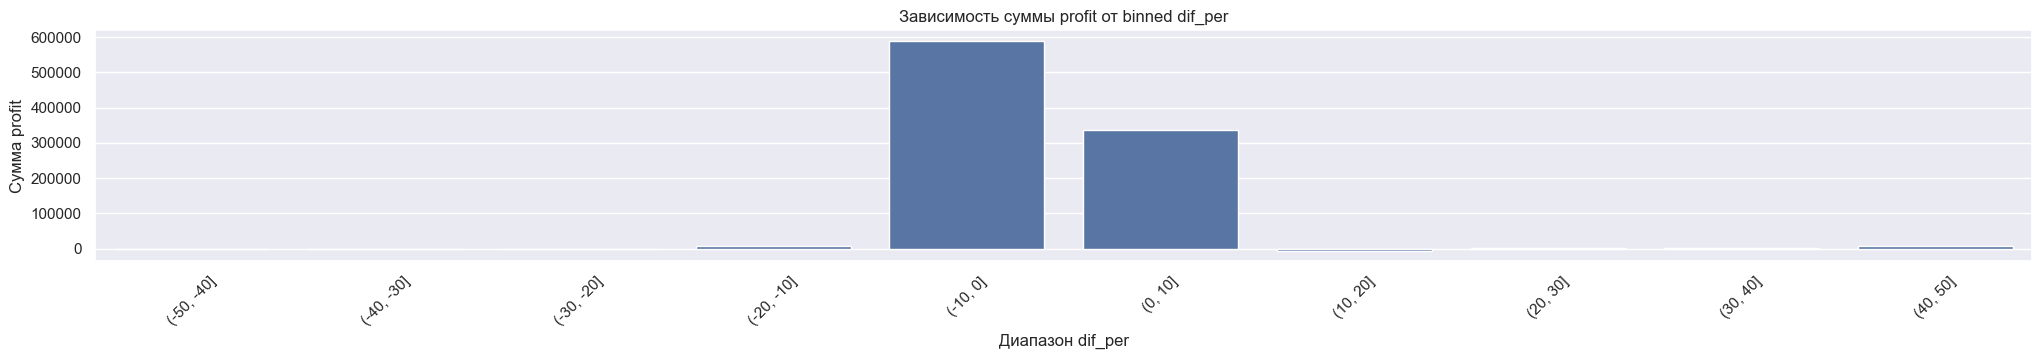

In [127]:
# # Создаем биннинг для 'dif_per'
# bins = pd.cut(df['dif_per'], bins=10)  # Разделяем 'dif_per' на 10 групп
# grouped_data = df.groupby(bins)['profit'].sum().reset_index()

# # Строим график зависимости
# sns.barplot(x=grouped_data['dif_per'].astype(str), y=grouped_data['profit'])
# plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
# plt.title('Зависимость суммы profit от binned dif_per')
# plt.xlabel('Диапазон dif_per')
# plt.ylabel('Сумма profit')
# plt.show()

# Создаем список границ бинов от 0 до 100 с шагом 10
custom_bins = list(range(-50, 51, 10))

# Создаем биннинг для 'dif_per' с пользовательскими диапазонами
bins = pd.cut(df['dif_per'], bins=custom_bins)

# Группируем данные и суммируем 'profit'
grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()

# Строим график зависимости
sns.barplot(x=grouped_data['dif_per'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned dif_per')
plt.xlabel('Диапазон dif_per')
plt.ylabel('Сумма profit')
plt.show()


C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\2276735194.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()


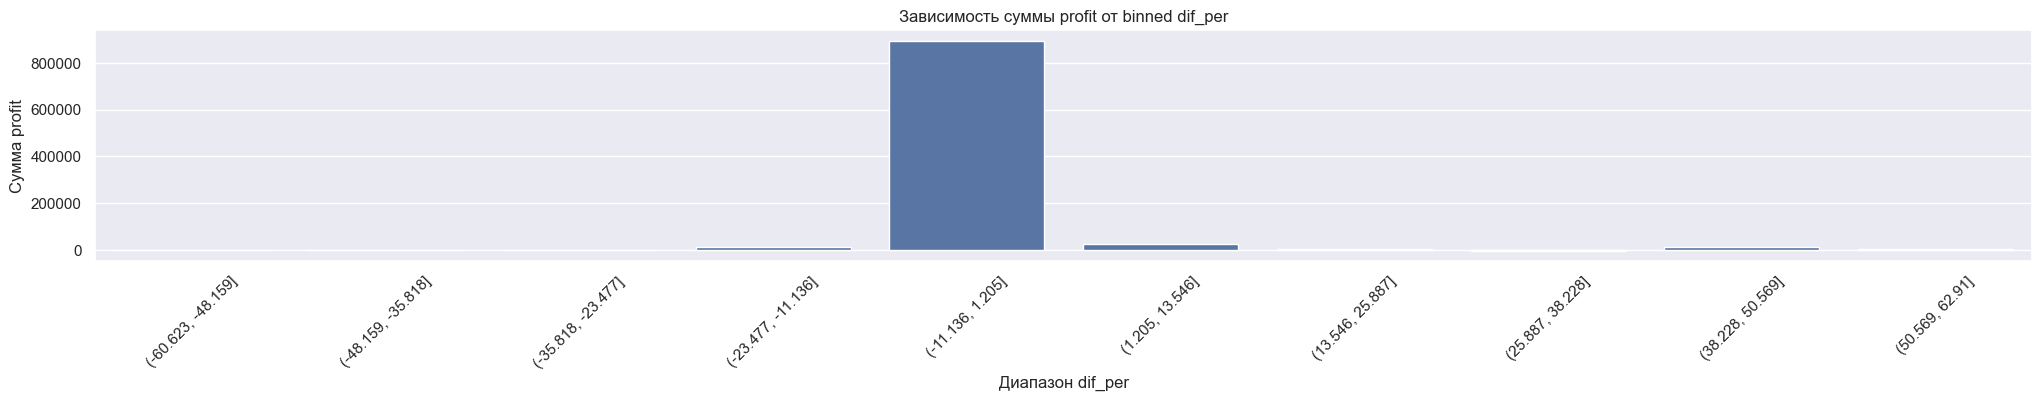

In [128]:
# Создаем биннинг для 'dif_per'
bins = pd.cut(df_2000['dif_per'], bins=10)  # Разделяем 'dif_per' на 10 групп
grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()

# Строим график зависимости
sns.barplot(x=grouped_data['dif_per'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned dif_per')
plt.xlabel('Диапазон dif_per')
plt.ylabel('Сумма profit')
plt.show()

In [129]:
# Добавление колонки с временем
df_2000['time'] = df_2000['tradedate'].dt.time

df_2000

C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\2771467188.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2000['time'] = df_2000['tradedate'].dt.time


,tradedate,open,high,low,close,avg_per,tvi,cci,t3,ghl,sig,sig_open,buy_sell,profit,dif_per,time
6173,2015-03-02 10:05:00,89890.0,90030.0,89550.0,89760.0,39.51,-1,-1,-1,-1,1,89890.0,-1,-170.0,1.06,10:05:00
6185,2015-03-02 11:05:00,90060.0,90220.0,89980.0,90060.0,44.70,1,1,1,1,1,90060.0,1,510.0,2.54,11:05:00
6196,2015-03-02 12:00:00,90570.0,90580.0,90270.0,90350.0,37.23,1,1,1,1,1,90570.0,1,-450.0,0.43,12:00:00
6217,2015-03-02 13:45:00,90120.0,90200.0,90070.0,90140.0,30.32,-1,-1,-1,-1,1,90120.0,-1,220.0,-0.38,13:45:00
6226,2015-03-02 14:30:00,89900.0,89930.0,89530.0,89670.0,30.73,-1,-1,-1,-1,1,89900.0,-1,50.0,0.61,14:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410385,2024-12-17 13:20:00,73760.0,73820.0,73730.0,73790.0,37.58,-1,-1,-1,-1,1,73760.0,-1,220.0,-0.24,13:20:00
410396,2024-12-17 14:20:00,73540.0,73540.0,73330.0,73340.0,37.67,-1,-1,-1,-1,1,73540.0,-1,290.0,0.30,14:20:00
410413,2024-12-17 15:45:00,73250.0,73260.0,73150.0,73220.0,42.49,1,1,1,1,1,73250.0,1,-270.0,-0.13,15:45:00
410419,2024-12-17 16:15:00,72980.0,72990.0,72720.0,72770.0,41.44,-1,-1,-1,-1,1,72980.0,-1,370.0,-0.24,16:15:00


C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\3076523532.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(bins)['profit'].sum().reset_index()
C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\3076523532.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data_cnt = df.groupby(bins)['profit'].count().reset_index()


     time_in_hours_x  profit_x   time_in_hours_y  profit_y  profit_avg
25   (9.938, 10.055]  143030.0   (9.938, 10.055]       279  512.652330
0     (6.988, 7.118]   50980.0    (6.988, 7.118]       106  480.943396
89  (17.458, 17.575]   40380.0  (17.458, 17.575]       210  192.285714
45  (12.288, 12.405]   28520.0  (12.288, 12.405]       198  144.040404
10    (8.175, 8.292]    1420.0    (8.175, 8.292]        10  142.000000
38  (11.465, 11.582]   22100.0  (11.465, 11.582]       182  121.428571
93  (17.928, 18.045]   23860.0  (17.928, 18.045]       197  121.116751
29  (10.407, 10.525]   34540.0  (10.407, 10.525]       290  119.103448
43   (12.052, 12.17]   46600.0   (12.052, 12.17]       438  106.392694
17    (8.998, 9.115]   20820.0    (8.998, 9.115]       201  103.582090
87   (17.222, 17.34]   42210.0   (17.222, 17.34]       411  102.700730
52   (13.11, 13.228]   24550.0   (13.11, 13.228]       242  101.446281
88   (17.34, 17.458]   17710.0   (17.34, 17.458]       189   93.703704
96   (

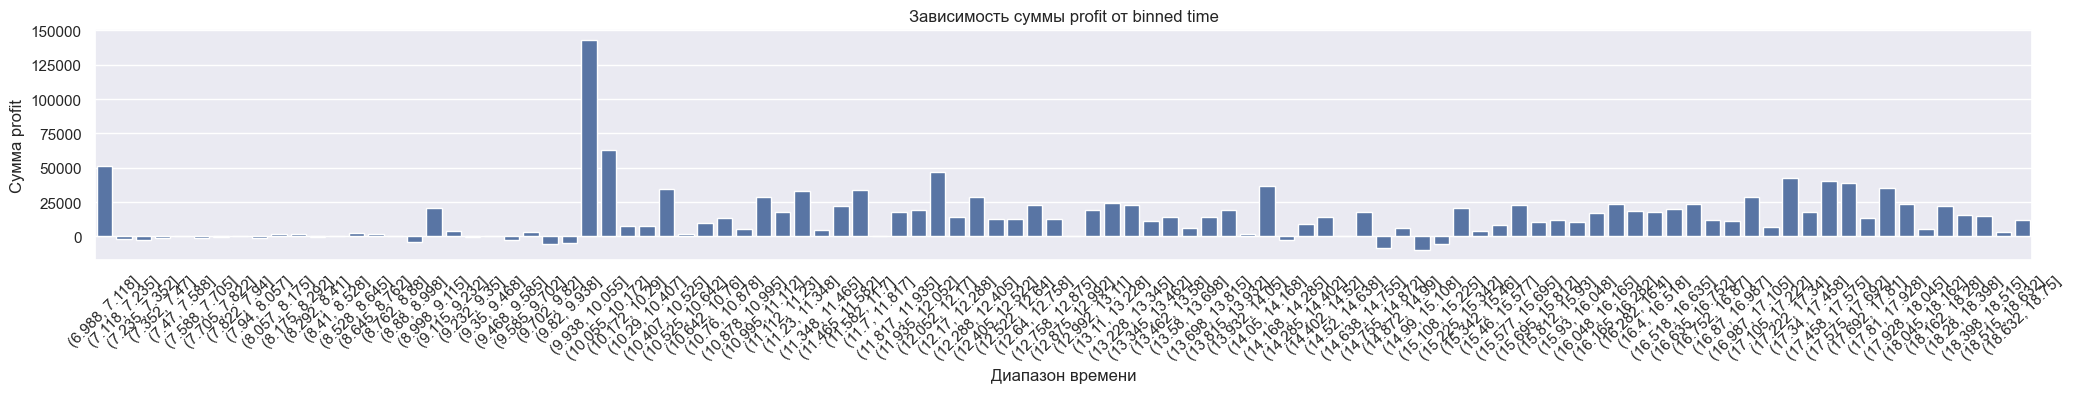

In [130]:
# Добавление колонки с временем
df['time'] = df['tradedate'].dt.time

# Преобразуем колонку 'time' в часы (дробное значение)
df['time_in_hours'] = pd.to_datetime(df['time'], format='%H:%M:%S').dt.hour + \
                      pd.to_datetime(df['time'], format='%H:%M:%S').dt.minute / 60 + \
                      pd.to_datetime(df['time'], format='%H:%M:%S').dt.second / 3600

# Создаем биннинг для 'time_in_hours'
bins = pd.cut(df['time_in_hours'], bins=100)  # Разделяем 'time_in_hours' на 10 групп
grouped_data = df.groupby(bins)['profit'].sum().reset_index()
# print(grouped_data)
grouped_data_cnt = df.groupby(bins)['profit'].count().reset_index()
# print(grouped_data_cnt)
df_merge = pd.merge(grouped_data, grouped_data_cnt, left_index=True, right_index=True, suffixes=('_x', '_y'))  # suffixes=('_x', '_y') по умолчанию
df_merge['profit_avg'] = df_merge['profit_x'] / df_merge['profit_y']
print(df_merge.sort_values (by='profit_avg', ascending=False).head(20))

# Строим график зависимости
sns.barplot(x=grouped_data['time_in_hours'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned time')
plt.xlabel('Диапазон времени')
plt.ylabel('Сумма profit')
plt.show()

C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\565758380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2000['time'] = df_2000['tradedate'].dt.time
C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\565758380.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2000['time_in_hours'] = pd.to_datetime(df_2000['time'], format='%H:%M:%S').dt.hour + \
C:\Users\Alkor\AppData\Local\Temp\ipykernel_2592\565758380.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True 

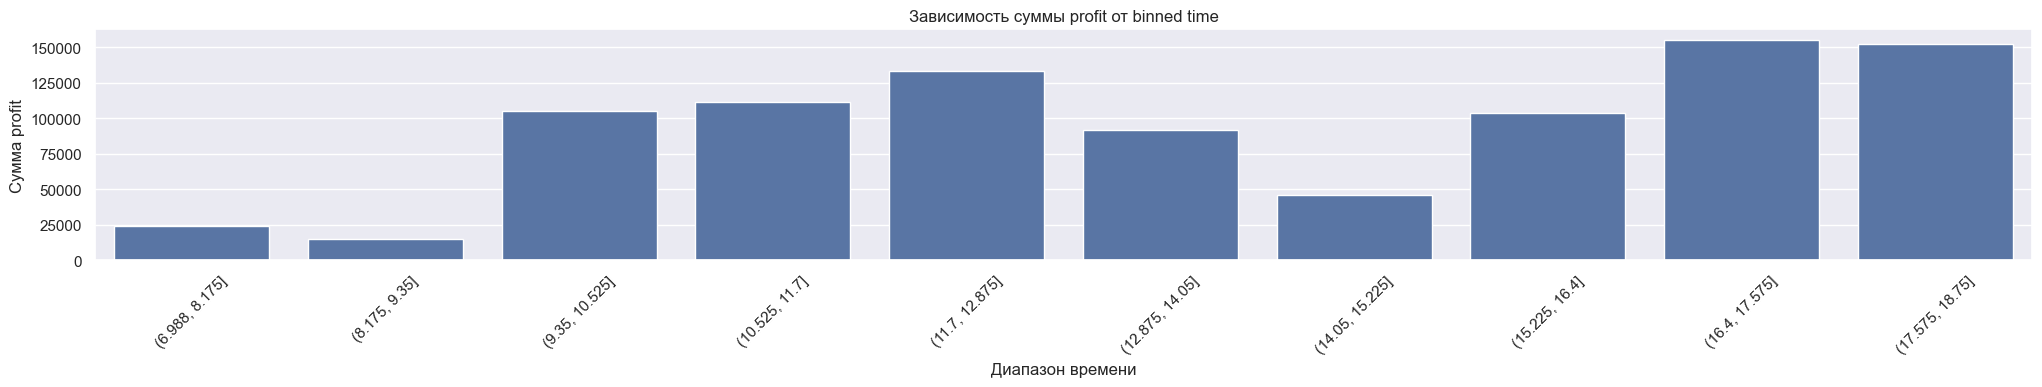

In [131]:
# Добавление колонки с временем
df_2000['time'] = df_2000['tradedate'].dt.time

# Преобразуем колонку 'time' в часы (дробное значение)
df_2000['time_in_hours'] = pd.to_datetime(df_2000['time'], format='%H:%M:%S').dt.hour + \
                           pd.to_datetime(df_2000['time'], format='%H:%M:%S').dt.minute / 60 + \
                           pd.to_datetime(df_2000['time'], format='%H:%M:%S').dt.second / 3600

# Создаем биннинг для 'time_in_hours'
bins = pd.cut(df_2000['time_in_hours'], bins=10)  # Разделяем 'time_in_hours' на 10 групп
grouped_data = df_2000.groupby(bins)['profit'].sum().reset_index()

# Строим график зависимости
sns.barplot(x=grouped_data['time_in_hours'].astype(str), y=grouped_data['profit'])
plt.xticks(rotation=45)  # Поворачиваем подписи оси X для читаемости
plt.title('Зависимость суммы profit от binned time')
plt.xlabel('Диапазон времени')
plt.ylabel('Сумма profit')
plt.show()

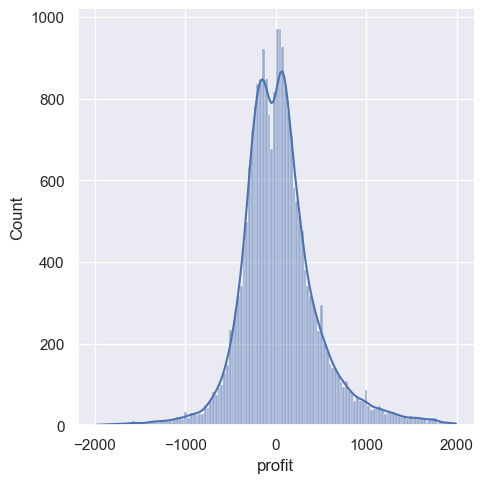

In [132]:
sns.set(rc={'figure.figsize':(25,5)})
sns.displot(df_2000['profit'], kde=True)